In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import os
import cv2
import random
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import splitfolders
from sklearn import metrics
from keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
splitfolders.ratio('../data/images', output='../data/split_data', ratio=(0.7, 0.15, 0.15))

Copying files: 1176 files [00:00, 1272.58 files/s]


In [3]:
train_path = '../data/split_data/train'
validation_path = '../data/split_data/val'
test_path = '../data/split_data/test'

In [4]:
train_datagen = ImageDataGenerator(zoom_range=0.3, 
                                   horizontal_flip=True, 
                                   rotation_range=10, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   brightness_range=[0.4, 1.5], 
                                   fill_mode='nearest')
datagen = ImageDataGenerator()

train_generator1 = train_datagen.flow_from_directory(train_path, class_mode='categorical', target_size=(224, 224), color_mode='rgb', batch_size=5, shuffle=True)
validation_generator1 = datagen.flow_from_directory(validation_path, class_mode='categorical', target_size=(224, 224), color_mode='rgb', batch_size=5, shuffle=True)
test_generator1 = datagen.flow_from_directory(test_path, class_mode='categorical', target_size=(224, 224), color_mode='rgb', batch_size=5, shuffle=True)

Found 820 images belonging to 20 classes.
Found 171 images belonging to 20 classes.
Found 185 images belonging to 20 classes.


### VGG16

In [5]:
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=20)
vgg16.trainable = False

model1 = keras.models.Sequential()
model1.add(vgg16)
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.ReLU())
model1.add(keras.layers.GlobalMaxPooling2D())
model1.add(keras.layers.Dropout(0.2))
model1.add(keras.layers.Dense(20))
model1.add(keras.layers.Softmax())

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7, 7, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 20)                1

In [9]:
opt = keras.optimizers.Adam()
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=7, verbose=1, restore_best_weights=True)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model1_history = model1.fit(train_generator1,
batch_size=5,
epochs=100,
validation_data = validation_generator1,
callbacks  = [early_stop])

model1.save_weights("vgg16.h5")

Epoch 1/100
164/164 [==============================] - 27s 102ms/step - loss: 9.3270 - accuracy: 0.0805 - val_loss: 6.7828 - val_accuracy: 0.2105
Epoch 2/100
164/164 [==============================] - 16s 96ms/step - loss: 6.2801 - accuracy: 0.1988 - val_loss: 4.1171 - val_accuracy: 0.3684
Epoch 3/100
164/164 [==============================] - 16s 95ms/step - loss: 5.3750 - accuracy: 0.2817 - val_loss: 3.0898 - val_accuracy: 0.4912
Epoch 4/100
164/164 [==============================] - 16s 100ms/step - loss: 4.2052 - accuracy: 0.3634 - val_loss: 2.5415 - val_accuracy: 0.5263
Epoch 5/100
164/164 [==============================] - 15s 93ms/step - loss: 3.7831 - accuracy: 0.3659 - val_loss: 2.5745 - val_accuracy: 0.5088
Epoch 6/100
164/164 [==============================] - 15s 94ms/step - loss: 3.3331 - accuracy: 0.4439 - val_loss: 2.1151 - val_accuracy: 0.6199
Epoch 7/100
164/164 [==============================] - 17s 106ms/step - loss: 3.1444 - accuracy: 0.4695 - val_loss: 2.0829 - val

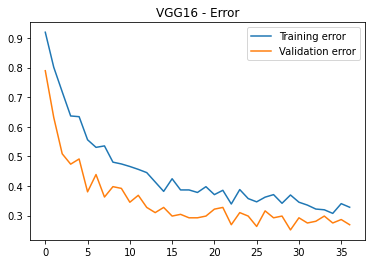

In [10]:
history_df = pd.DataFrame(model1_history.history)
history_df.head()
plt.title('VGG16 - Error')
plt.plot((1-history_df['accuracy']), label = 'Training error')
plt.plot((1-history_df['val_accuracy']), label = 'Validation error')
plt.legend()
plt.show()

In [11]:
train_loss, train_accuracy = model1.evaluate(x = train_generator1, verbose = 1)
print('Training Accuracy: ', round((train_accuracy * 100), 2), "%")

valid_loss, valid_accuracy = model1.evaluate(x = validation_generator1, verbose = 1)
print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

test_loss, test_accuracy = model1.evaluate(x = test_generator1, verbose = 1)
print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

164/164 [==============================] - 14s 87ms/step - loss: 0.5491 - accuracy: 0.8622
Training Accuracy:  86.22 %
35/35 [==============================] - 1s 33ms/step - loss: 1.4849 - accuracy: 0.7485
Validation Accuracy:  74.85 %
37/37 [==============================] - 1s 34ms/step - loss: 1.5400 - accuracy: 0.6757
Test Accuracy:  67.57 %


### EfficientNetB0

In [6]:
effnet = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=20)
effnet.trainable = False

model2 = keras.models.Sequential()
model2.add(effnet)
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.ReLU())
model2.add(keras.layers.GlobalMaxPooling2D())
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(20))
model2.add(keras.layers.Softmax())

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 1280)       5120      
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 7, 7, 1280)        0         
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 20)               

In [13]:
opt = keras.optimizers.Adam()
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1, restore_best_weights=True)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model2_history = model2.fit(train_generator1,
batch_size=5,
epochs=100,
validation_data = validation_generator1,
callbacks  = [early_stop])

model2.save_weights("efficientNetB0.h5")

Epoch 1/100
164/164 [==============================] - 22s 100ms/step - loss: 7.0279 - accuracy: 0.2829 - val_loss: 1.8523 - val_accuracy: 0.7018
Epoch 2/100
164/164 [==============================] - 15s 93ms/step - loss: 3.0915 - accuracy: 0.5927 - val_loss: 1.2555 - val_accuracy: 0.7661
Epoch 3/100
164/164 [==============================] - 15s 92ms/step - loss: 2.4774 - accuracy: 0.6732 - val_loss: 1.6074 - val_accuracy: 0.7661
Epoch 4/100
164/164 [==============================] - 15s 91ms/step - loss: 2.1837 - accuracy: 0.7195 - val_loss: 1.0600 - val_accuracy: 0.8363
Epoch 5/100
164/164 [==============================] - 15s 90ms/step - loss: 1.8458 - accuracy: 0.7415 - val_loss: 0.9805 - val_accuracy: 0.8421
Epoch 6/100
164/164 [==============================] - 15s 90ms/step - loss: 1.6169 - accuracy: 0.7683 - val_loss: 1.0237 - val_accuracy: 0.8713
Epoch 7/100
164/164 [==============================] - 15s 90ms/step - loss: 1.6403 - accuracy: 0.7707 - val_loss: 0.5809 - val_a

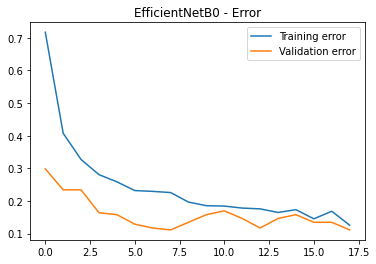

In [14]:
history_df = pd.DataFrame(model2_history.history)
history_df.head()
plt.title('EfficientNetB0 - Error')
plt.plot((1-history_df['accuracy']), label = 'Training error')
plt.plot((1-history_df['val_accuracy']), label = 'Validation error')
plt.legend()
plt.show()

In [15]:
train_loss, train_accuracy = model2.evaluate(x = train_generator1, verbose = 1)
print('Training Accuracy: ', round((train_accuracy * 100), 2), "%")

valid_loss, valid_accuracy = model2.evaluate(x = validation_generator1, verbose = 1)
print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

test_loss, test_accuracy = model2.evaluate(x = test_generator1, verbose = 1)
print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

164/164 [==============================] - 14s 86ms/step - loss: 0.5375 - accuracy: 0.9183
Training Accuracy:  91.83 %
35/35 [==============================] - 1s 29ms/step - loss: 0.9656 - accuracy: 0.8889
Validation Accuracy:  88.89 %
37/37 [==============================] - 1s 28ms/step - loss: 0.9466 - accuracy: 0.8595
Test Accuracy:  85.95 %


### Precision, Recall, and F1 score

### VGG16

In [16]:
test_generator1.batch_size  = test_generator1.samples
test_dataset = next(test_generator1)
test = (np.argmax(test_dataset[1], axis=1))
predictions = model1.predict(test_generator1)
predictions = np.argmax(predictions, axis = 1)

target = ["Category/Class {}".format(i) for i in range(20)]
print(classification_report(np.argmax(test_dataset[1], axis=1), predictions, target_names=target))

1/1 [==============================] - 27s 27s/step
                   precision    recall  f1-score   support

 Category/Class 0       0.60      0.75      0.67         8
 Category/Class 1       1.00      0.78      0.88         9
 Category/Class 2       0.80      0.80      0.80        10
 Category/Class 3       0.89      0.80      0.84        10
 Category/Class 4       0.75      0.33      0.46         9
 Category/Class 5       0.70      0.78      0.74         9
 Category/Class 6       0.67      0.89      0.76         9
 Category/Class 7       0.53      0.89      0.67         9
 Category/Class 8       0.60      0.67      0.63         9
 Category/Class 9       1.00      0.89      0.94         9
Category/Class 10       0.83      0.56      0.67         9
Category/Class 11       1.00      0.78      0.88         9
Category/Class 12       0.86      0.67      0.75         9
Category/Class 13       0.50      0.33      0.40         9
Category/Class 14       0.39      0.78      0.52         9
Cat

### EfficientNetB0

In [17]:
test_generator1.batch_size  = test_generator1.samples
test_dataset = next(test_generator1)
test = (np.argmax(test_dataset[1], axis=1))
predictions = model2.predict(test_generator1)
predictions = np.argmax(predictions, axis = 1)

target = ["Category {}".format(i) for i in range(20)]
print(classification_report(np.argmax(test_dataset[1], axis=1), predictions, target_names=target))

1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

  Category 0       1.00      0.88      0.93         8
  Category 1       1.00      1.00      1.00         9
  Category 2       0.91      1.00      0.95        10
  Category 3       0.88      0.70      0.78        10
  Category 4       1.00      0.56      0.71         9
  Category 5       0.73      0.89      0.80         9
  Category 6       1.00      1.00      1.00         9
  Category 7       0.56      1.00      0.72         9
  Category 8       0.82      1.00      0.90         9
  Category 9       1.00      0.89      0.94         9
 Category 10       1.00      1.00      1.00         9
 Category 11       1.00      0.89      0.94         9
 Category 12       0.89      0.89      0.89         9
 Category 13       0.78      0.78      0.78         9
 Category 14       0.64      1.00      0.78         9
 Category 15       1.00      0.40      0.57        10
 Category 16       0.91      1.